In [3]:
%load_ext autoreload
%autoreload 2
%run ../draw_functions.py
%run ../kstest.py

In [4]:
from draw_functions import *
from kstest import *

In [6]:
#read csv
df = pd.read_csv('../csv/La_commande.csv')

#ajout du slope
df['slope'] = df.groupby('ResultCurve_id').apply(lambda group: group['xvalue'].diff() / group['xtime'].diff(), include_groups=False).reset_index(level=0, drop=True)
df_02_08 = df[(df['xtime'] >= 0.2) & (df['xtime'] <= 0.8)]
df

,ResultCurve_id,xtime,xvalue,Batch,Sample_Code,slope
0,F7AA8B41-AAC0-4E36-B830-01B26BAD706B,0.015000,2.078924,104006A,N8A0YIU98,NaN
1,F7AA8B41-AAC0-4E36-B830-01B26BAD706B,0.025000,2.045029,104006A,N8A0YIU98,-3.38955
2,F7AA8B41-AAC0-4E36-B830-01B26BAD706B,0.035000,2.022432,104006A,N8A0YIU98,-2.25970
3,F7AA8B41-AAC0-4E36-B830-01B26BAD706B,0.045000,1.999835,104006A,N8A0YIU98,-2.25970
4,F7AA8B41-AAC0-4E36-B830-01B26BAD706B,0.051933,1.952833,104006A,N8A0YIU98,-6.77910
...,...,...,...,...,...,...
8909,5D68614F-D84B-48D8-8465-FE8B87DED588,1.246400,4.429012,101503A,N8A0YIP71,0.00000
8910,5D68614F-D84B-48D8-8465-FE8B87DED588,1.273333,4.429012,101503A,N8A0YIP71,0.00000
8911,5D68614F-D84B-48D8-8465-FE8B87DED588,1.283333,4.440311,101503A,N8A0YIP71,1.12985
8912,5D68614F-D84B-48D8-8465-FE8B87DED588,1.293333,4.440311,101503A,N8A0YIP71,0.00000


In [ ]:
df_035_065 = df[(df['xtime'] >= 0.35) & (df['xtime'] <= 0.65)]

#ajout du slope
df_035_065['slope'] = df_035_065.groupby('ResultCurve_id').apply(lambda group: group['xvalue'].diff() / group['xtime'].diff(), include_groups=False).reset_index(level=0, drop=True)
df_035_065

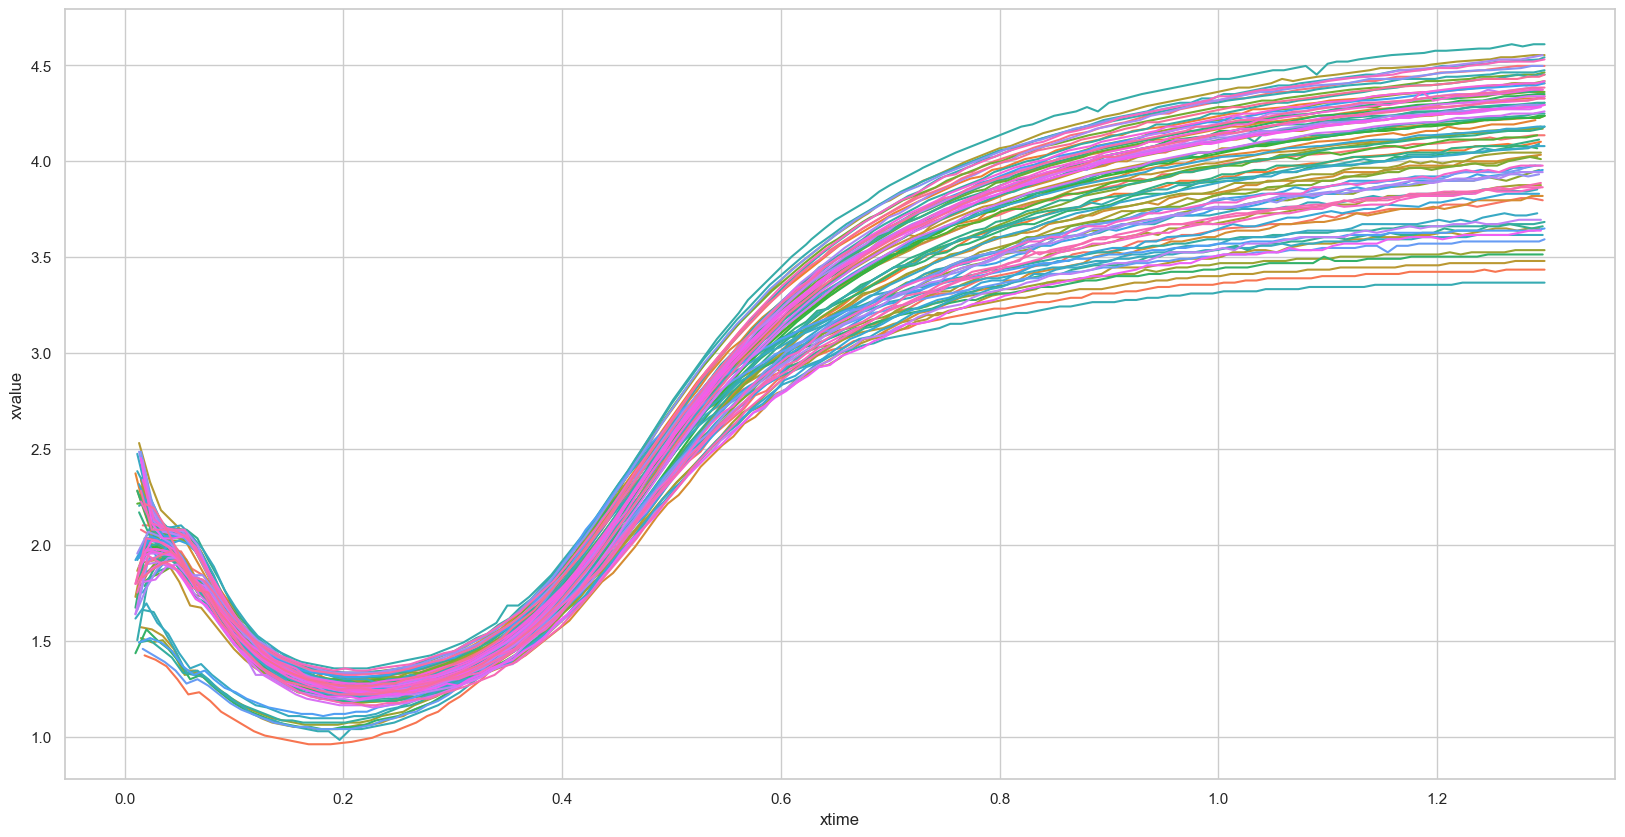

In [23]:
dessiner_commande(df)

## Analyse des pentes

In [2]:
dessiner_commande_slope(df_02_08, 1, unified=False)

NameError: name 'dessiner_commande_slope' is not defined

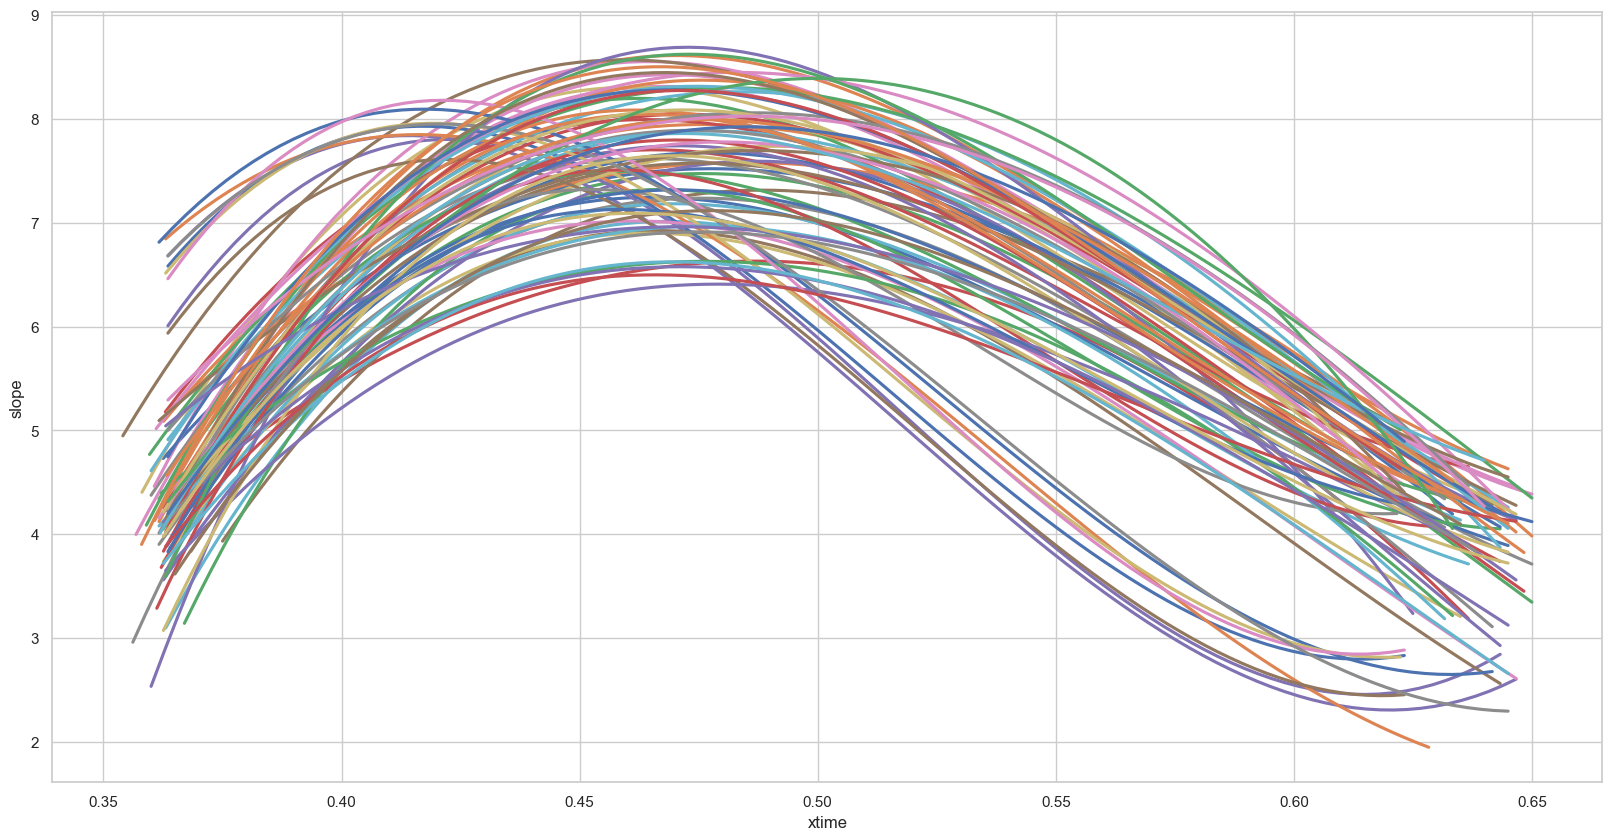

In [36]:
dessiner_commande_slope(df_035_065, 3 ,unified=False)

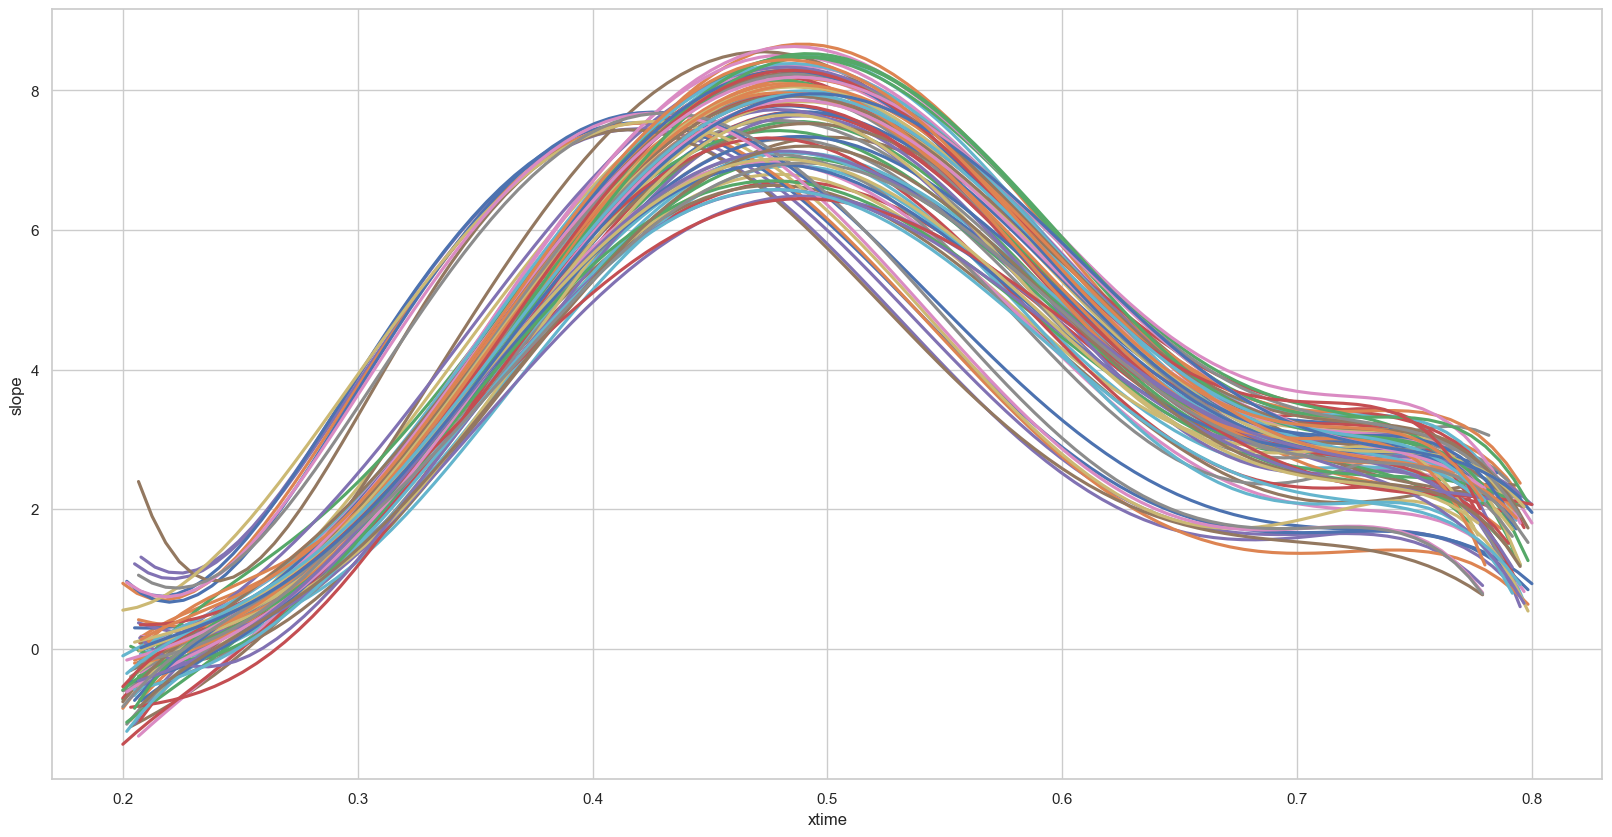

In [10]:
dessiner_commande_slope(df_02_08, 6 ,unified=False)

## Test Type

In [13]:
max_slope_sample_xtime

Batch
095801A    0.435000
095801A    0.423333
095801A    0.431667
095801A    0.430000
095801A    0.426667
             ...   
115915A    0.467400
115915A    0.467400
115915A    0.470000
115915A    0.478333
115915A    0.486667
Name: xtime, Length: 82, dtype: float64

In [ ]:
df_04_08 = df[(df['xtime'] > 0.35) & (df['xtime'] < 0.65)]
for sample in df_04_08['Sample_Code'].unique():
    df_sample = df_04_08[df_04_08['Sample_Code'] == sample]

    z1 = np.polyfit(df_sample['xtime'], df_sample['slope'], 6)
    p1 = np.poly1d(z1)

    # Update the 'fitted_slope' in df_data for the current sample
    df_04_08.loc[df_04_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])

# I want a new dataframe with three columns: OrderNo, std_dev_batch, std_dev_sample
df_std_dev = pd.DataFrame(columns=['std_dev_sample'])

max_slope_sample_xtime = df_04_08.loc[df_04_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
#max_slope_batch_xtime = max_slope_sample_xtime.groupby('Batch').median()

#std_dev_batch = round(np.std(max_slope_batch_xtime) * 1000, 2)
std_dev_sample = round(np.std(max_slope_sample_xtime) * 1000, 2)

df_std_dev.loc[len(df_std_dev)] = [std_dev_sample]

In [10]:
df_std_dev

,std_dev_sample
0,21.17


In [29]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

#round xtime to 2 decimal places
df['xtime'] = df['xtime'].round(2)

# Trier le DataFrame par 'xtime' puis par 'xvalue'
df_sorted = df.sort_values(['xtime', 'xvalue'])

# Grouper par 'xtime' et calculer la différence entre deux 'xvalue' consécutifs
df_sorted['xvalue_diff'] = df_sorted.groupby('xtime')['xvalue'].diff().abs()

# Grouper par 'xtime' et exclure la première et la dernière valeur
grouped = df_sorted.groupby('xtime')

# For each group, select all rows except the first and last, then calculate the max
max_diff = grouped.apply(lambda group: group.iloc[1:-1]['xvalue_diff'].max(), include_groups=False)

# Créer une nouvelle DataFrame à partir des différences maximales
df_max_diff = pd.DataFrame(max_diff).reset_index()
# Rename the unnamed column
df_max_diff = df_max_diff.rename(columns={df_max_diff.columns[1]: 'xvalue_diff'})

df_max_diff['xvalue_diff'] = scaler.fit_transform(df_max_diff[['xvalue_diff']])

df_max_diff

,xtime,xvalue_diff
0,0.01,0.618232
1,0.02,0.236465
2,0.03,0.479408
3,0.04,1.000000
4,0.05,0.998149
...,...,...
125,1.26,0.271171
126,1.27,0.340583
127,1.28,0.201758
128,1.29,0.201758


<Axes: xlabel='xtime', ylabel='xvalue_diff'>

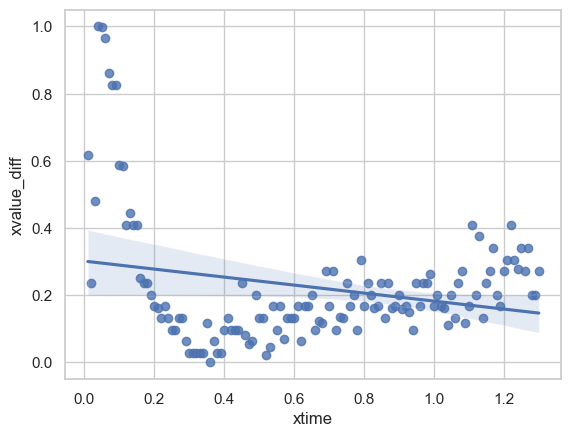

In [30]:
# Plot the max differences
sns.regplot(x='xtime', y='xvalue_diff', data=df_max_diff, scatter=True)

In [8]:
for sample in df_02_08['Sample_Code'].unique():
    df_sample = df_02_08[df_02_08['Sample_Code'] == sample]

    z1 = np.polyfit(df_sample['xtime'], df_sample['slope'], 3)
    p1 = np.poly1d(z1)

    # Update the 'fitted_slope' in df_data for the current sample
    df_02_08.loc[df_02_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])
max_slope_sample_xtime = df_02_08.loc[df_02_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
max_slope_sample_xtime

Batch
095801A    0.395000
095801A    0.403333
095801A    0.411667
095801A    0.414933
095801A    0.415467
             ...   
115915A    0.519333
115915A    0.503333
115915A    0.500000
115915A    0.508333
115915A    0.506667
Name: xtime, Length: 82, dtype: float64

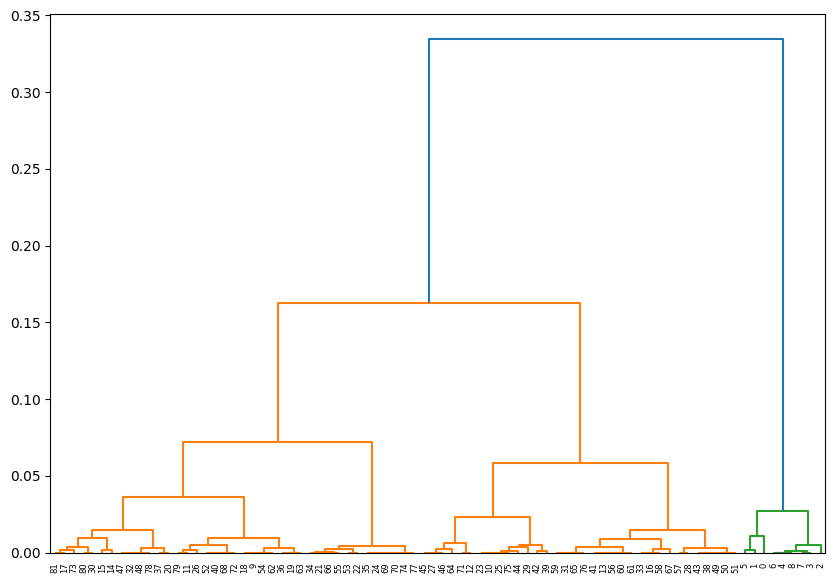

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Reshape your data to a 2D array
data = np.array(max_slope_sample_xtime).reshape(-1, 1)

# Generate the links between the clusters
linked = linkage(data, 'ward')

# Create a new plot
plt.figure(figsize=(10, 7))

# Draw the dendrogram
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)

# Show the plot
plt.show()

In [12]:
from utils import (distance)

# Find the xtime corresponding to the max slope for each group

max_slope_sample_xtime = df_02_08.loc[df_02_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
dist = distance(max_slope_sample_xtime)*100

dist

13.448255448597656